In [1]:
__copyright__ = "Reiner Lemoine Institut gGmbH"
__license__   = "GNU Affero General Public License Version 3 (AGPL-3.0)"
__url__       = "https://github.com/AnyaHe/survey_eval/blob/master/LICENSE"
__author__    = "AnyaHe, ricrei, a-linke"

# Introduction of functionalities
This is a short introduction into the functionalities that come with the data. Of course, all methods can be adapted to the users own needs, but some basic methods and functions used for the paper are provided. 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path
import pandas as pd
from tools import tools
from tools import plots

In [4]:
#load survey
cur_dir = Path(os.getcwd())
table_values = pd.read_csv(os.path.join(cur_dir,'data/Evaluation_Table.csv'), sep=";").\
    set_index('Model / framework').fillna(0)
nr_of_surveys = len(table_values)

## General evaluation: Displayed information
Inside the evaluation table, you can find the answers of all models that participated in the survey. A clean version of the survey can be found in data/Survey_flexibility_options_in_open_energy_models.pdf. We removed all personal data on the participants and added the information on the modeling language. The table can be used to look for models including certain technologies or aspects.

In [5]:
# display all models that have electric vehicles predefined
table_values.loc[table_values['EV/def']==1]['EV/def']

Model / framework
eGo               1.0
DIETER            1.0
Dispa-SET         1.0
EnergyPLAN        1.0
EnergyScope       1.0
PyPSA             1.0
region4FLEX       1.0
Frigg             1.0
IRENA FlexTool    1.0
Name: EV/def, dtype: float64

In [6]:
# display all models that use Python as the modeling language
table_values.loc[table_values['Modeling language'].str.contains('Python')]['Modeling language']

Model / framework
eGo                  Python
Calliope             Python
Dispa-SET      GAMS, Python
oemof                Python
OMEGAlpes            Python
PyPSA                Python
region4FLEX          Python
RTestPSM             Python
Frigg                Python
GridCal              Python
urbs                 Python
pandapower           Python
OSeMOSYS       GLPK, Python
Name: Modeling language, dtype: object

In [7]:
# display the combination of the two
table_values.loc[table_values['Modeling language'].str.contains('Python')].loc[
    table_values['EV/def']==1][['Modeling language','EV/def']]

,Modeling language,EV/def
Model / framework,,
eGo,Python,1.0
Dispa-SET,"GAMS, Python",1.0
PyPSA,Python,1.0
region4FLEX,Python,1.0
Frigg,Python,1.0


## Model related evaluation: Technology representation
There is a set of functions which allows for the simple evaluation whether certain technologies are possible to represent or even predefined. A simple example is shown in the following.

In [8]:
# define technologies that should be checked for in the evaluation. Note that only technologies assessed in the last
# part of the survey can be checked for here. 
technology_dict = {
    'Supply': ['hard coal', 'lignite', 'oil', 'natural gas', 'CCGT', 'OCGT',
               'CHP', 'Bioenergy', 'geothermal', 'hydropower reservoir',
               'concentrated solar power', 'photovoltaic', 'wind onshore',
               'Wind-offshore', 'Run-of-river hydro', 'wave power',
               'tidal power', 'PEM-FC', 'SOFC', 'Nuclear'],
    'Demand': ['households', 'industrial load', 'service sector'],
    'Storage': ['PHS', 'Batteries', 'CAES', 'Caps', 'Flywheels'],
    'Sector\nCoupling': ['P2Gas', 'P2H2', 'HP', 'EV', 'Fuels (H2)',
                        'Heat storage', 'V2Grid'],
    'Network': ['Distribution Grid', 'Transmission Grid', 'interconnectors',
                'network extension', 'switches']
}

In [9]:
# use get_technology_representation_models_from_technology_dict to get the representation of the different categories
models_pos_df, models_pred_df = \
    tools.get_technology_representation_models_from_technology_dict(table_values,
                                                              technology_dict)

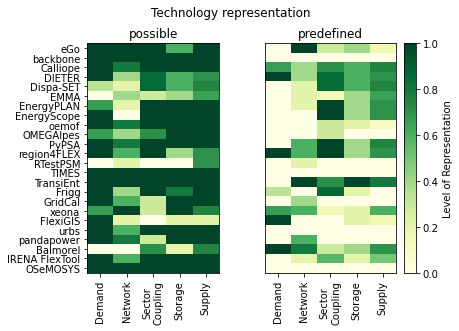

In [10]:
# use plot function to visualise the representation
plots.plot_representation_dual(models_pos_df, models_pred_df, title='Technology representation', 
                         subtitle_1='possible', subtitle_2='predefined')

## Model related evaluation: Rated evaluation of different parameters
There is the possibility to define and rate certain parameters that one wants evaluated. Therefore predefined functions for the evaluation exist, but these can be replaced by user-defined functions where necessary.

As a simple example assume we want to get the model out of EMMA, oemof, PyPSA and TIMES which best represents photovoltaics and concentrated solar power (CSP), where it is double as important to be able to represent photovoltaics than CSP. We furthermore want to evaluate the implementation of ramp rate, efficiency and recovery time within the models. They are equally important for us.

In [11]:
models = ['EMMA', 'oemof', 'PyPSA', 'TIMES']

In [12]:
# first step is to define the dictionary with the parameters we want to evaluate
parameters_with_weights = {
    'Technology\nRepresentation': {
                'concentrated solar': 1, 'photovoltaic': 2},
    'Detailed\nCharacteristics': {
                'efficiency': 1, 'ramping': 1, 'recovery time': 1}
}

In [13]:
# we now need to define which options from the survey are "rewarded" with which percentage, 
# we therefore create a second dictionary, using the default evaluation dict
evaluation_parameters = tools.default_evaluation_parameters()

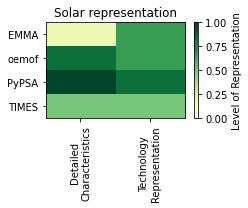

In [14]:
# We evaluate the chosen parameters using the get_weighted_models_from_evaluation_dict method and plot the results
weighted_models_supply_df = tools.get_weighted_models_from_evaluation_dicts(
    models, parameters_with_weights, evaluation_parameters, table_values)
plots.plot_representation_single(
    weighted_models_supply_df, 'Solar representation', figsize=(3.5, 3))

With the default parameters we would probably choose PyPSA in this case.

In [15]:
# We now dont want to use the default evaluation but define our own rating.
# The dictionary has to be designed in a way that the entries of the parameters_with_weights has to be present as
# key in the evaluation_parameters dictionary.
evaluation_parameters = {}
# assume it is equally beneficial if CSP is possible to implement or predifined. We can then choose to give a 
# list of the entries of the survey table that count as fulfilled
evaluation_parameters['concentrated solar'] = ['concentrated solar power/pos', 'concentrated solar power/def']
# For PV we don't care whether the technology is predefined, we want to model it ourselves, therefore only the
# possibility to model is important to us
evaluation_parameters['photovoltaic'] = {'photovoltaic/pos': 1.0}
# For efficiency, we prefer a function over a fixed value, but it is not too important. We therefore value function as 
# 100% and fixed value as 80%.
evaluation_parameters['efficiency']= {'efficiency function': 1.0, 'efficiency fixed value': 0.8}
# For ramping we assume equally important reponse time and ramping.
evaluation_parameters['ramping'] = ['ramping yes', 'response time yes']
# For recovery time, we take the entry of the default evaluation parameters.
evaluation_parameters['recovery time'] = {'recovery time yes': 1.0}
# Note that it is also possible to define a bit more complex methods for the evaluation. These would have to be 
# added to tools and can then be called in the get_weighted_models_from_evaluation_dicts method. We would have a string 
# as entry in the evaluation_parameters then. Check e.g. 'decision making' in the method.

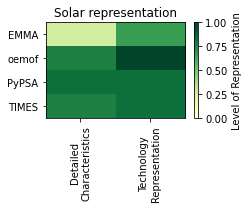

In [16]:
# We again evaluate the chosen parameters using the get_weighted_models_from_evaluation_dict method and 
# plot the results
weighted_models_df = tools.get_weighted_models_from_evaluation_dicts(
    models, parameters_with_weights, evaluation_parameters, table_values)
plots.plot_representation_single(
    weighted_models_df, 'Solar representation', figsize=(3.5, 3))

We would now probably choose oemof as a model.

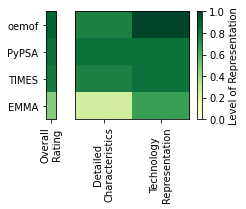

In [17]:
# If we want to plot the models in the order of their representation level and plot the same as well, 
# we can use a different plotting method.
rating = weighted_models_df.sum(axis=1).divide(2)
rating_df = pd.DataFrame(rating.sort_values(ascending=False)).rename(columns={0:'Overall\nRating'})
plots.plot_representation_holistic(rating_df,
    weighted_models_df.loc[
        rating.sort_values(ascending=False).index], figsize=(3.5, 3))

## Parameter related evaluation
To get an overview on the depicted modelling landscape, it is possible to check and visualise the percentage of models which display certain characteristics. Find a simple example below.

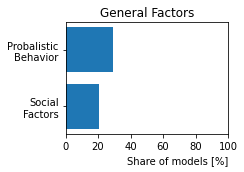

In [18]:
# show percentage of models, that have probabilistic and social factors included
generalfactors = table_values.loc[:, ['prob yes', 'social yes']].sum()
plots.plot_bar_horizontal(
        generalfactors, ['Probalistic\nBehavior', 'Social\nFactors'],
        title='General Factors', max_val=nr_of_surveys)

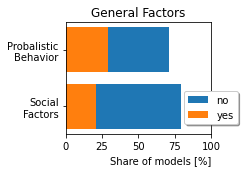

In [19]:
# show percentage of models, that have probabilistic and social factors included
generalfactors_yn = table_values.loc[:, ['prob yes','prob no', 'social yes', 'social no']].sum()
plots.plot_bar_horizontal(
        generalfactors_yn, ['Probalistic\nBehavior', 'Social\nFactors'],
        title='General Factors', max_val=nr_of_surveys, label_name='no_yes')

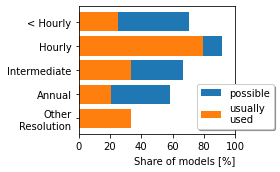

In [20]:
# plot temporal resolutions that are possible and usually used
temporal_resolution = table_values.loc[:, '<hourly/pos':'other temporal resolution'].sum()
temporal_resolution['other temporal resolution/pos'] = len(table_values['other temporal resolution'].to_numpy().nonzero()[0])
temporal_resolution['other temporal resolution/used'] = len(table_values['other temporal resolution'].to_numpy().nonzero()[0])

plots.plot_bar_horizontal(
    temporal_resolution, ['< Hourly', 'Hourly', 'Intermediate', 'Annual', 'Other\nResolution'],
    max_val=nr_of_surveys, figsize=(4., 2.5))

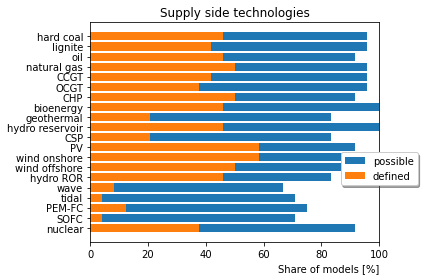

In [21]:
# plot which supply technologies are represented to what extent
convPP = table_values.loc[:, 'hard coal/pos':'CHP/def'].sum()
dispRES = table_values.loc[:, 'Bioenergy/pos':'concentrated solar power/def'].sum()
vRES = table_values.loc[:, 'photovoltaic/pos':'tidal power/def'].sum()
other_supply = table_values.loc[:, 'PEM-FC/pos':'Nuclear/def'].sum()

supply = pd.concat([convPP, dispRES, vRES, other_supply])

plots.plot_bar_horizontal(
    series=supply,
    x_labels=['hard coal', 'lignite', 'oil', 'natural gas',
              'CCGT', 'OCGT', 'CHP', 'bioenergy', 'geothermal',
              'hydro reservoir', 'CSP', 'PV', 'wind onshore',
              'wind offshore', 'hydro ROR', 'wave', 'tidal',
              'PEM-FC', 'SOFC', 'nuclear'],
    title='Supply side technologies', max_val=nr_of_surveys, label_name = 'pos_def', figsize=(6, 4))